In [2]:
## make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
from collections import namedtuple

from pa_lib.file import (
    project_dir,
    load_bin,
    load_pickle,
    load_xlsx,
    store_bin,
)
from pa_lib.data import as_dtype, dtFactor
from pa_lib.util import cap_words, collect, value

# Load data sets

In [3]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    spr_data = load_pickle("spr_data.pkl")

10:34:35 [INFO] Started loading binary file ...
10:34:35 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
10:34:36 [INFO] ... finished loading binary file in 1.07s (0.94s CPU)
10:34:36 [INFO] Started loading pickle file ...
10:34:36 [INFO] Reading from file C:\Users\kpf\data\axinova\spr_data.pkl
10:34:36 [INFO] ... finished loading pickle file in 0.08s (0.05s CPU)


# Filter data for merging

In [4]:
spr_data.dropna(subset=["PF"], inplace=True)

# Find mapping of Flächen to Stations

In [5]:
pd.DataFrame(dict(Station=ax_data.Station.unique()))

,Station
0,Aarau
1,Basel SBB
2,Bellinzona
3,Bern
4,Biel/Bienne
5,Brig
6,Chur
7,Fribourg
8,Genève Aéroport
9,Genève Cornavin


In [6]:
spr_data.columns

Index(['index', 'WT', 'Flaeche_ID', 'Anbieter', 'Spr_Flaeche_ID', 'Time',
       'Count', 'Nummer', 'PF', 'Position-Nr.', 'Gebiet', 'Gebietsbez.',
       'Gebiet Code', 'Adresszusatz', 'STM', 'EN-Nr.', 'NG-Nr.'],
      dtype='object')

## Problem cantons: ZH, GE, VD, BE, TI (> 1 station each)

In [7]:
def spr_list(column, cond, sep="\n"):
    for var, value in cond.items():
        print(f"--- {var} = {value} ---")
        print(collect(spr_data.loc[spr_data[var] == value, column], sep=sep))

In [8]:
spr_list("Adresszusatz", {"Gebiet Code": "ZH"})

--- Gebiet Code = ZH ---
Gleis 2, Sektor C, Fahrtreppenaufgang
Gleis 3, Sektor C, Fahrtreppenaufgang
Gleis 31/32, Sektor B, Aufgang Halle Löwenstrasse
Gleis 31/32, Sektor B, Wartezone
Gleis 33/34, Sektor B, Aufgang Halle Löwenstrasse
Gleis 33/34, Sektor B, Wartezone
Gleis 4, Sektor A, vis-à-vis Hausperron
Gleis 4, Sektor B, vis-à-vis Hausperron
Gleis 4, Sektor C, vis-à-vis Hausperron
Gleis 41, Linien 5,6,7,9,12, Sektor B
Gleis 41, Linien 5,6,7,9,12, Sektor C
Gleis 44, Linien 5,6,7,9,12, Sektor B
Gleis 44, Linien 5,6,7,9,12, Sektor C
Halle Kopfperron
Halle Landesmuseum, Abgänge S-Bahn Perron Gleis 41+42 / 43+44
Halle Löwenstrasse, Aufgang Gleis 6
Halle Löwenstrasse, Aufgang Gleis 7
Halle Löwenstrasse, Aufgang Shopville
Halle Museumstrasse, Passage Bahnhofstrasse
Halle Museumstrasse, Passage Löwenstrasse
Haupzugang, Kiosk
Passage Löwenstrasse
Passage Sihlquai, Liftschacht Gleis 10
Passage Sihlquai, Liftschacht Gleis 11
Passage Sihlquai, Liftschacht Gleis 6
Passage Sihlquai, Liftschacht G

In [9]:
from typing import Dict, NamedTuple

NrRange = namedtuple("NrRange", ["low", "high"], defaults=[None])
StationMapping = Dict[NrRange, str]
CantonMapping = Dict[str, str]


def map_stations(
    canton: str = None, cantons: CantonMapping = None, nr_ranges: StationMapping = None
) -> None:
    """
    Map spr_data records to Intervista Station names in-place, either per canton by 
    Flaechennummer ranges NrRange(low, high), or by directly mapping from canton 
    to station
    """
    if nr_ranges is not None and canton is not None:
        for nr_range, station_name in nr_ranges.items():
            if nr_range.high is None:
                nr_range = NrRange(nr_range.low, nr_range.low)
            spr_data.loc[
                (spr_data["Gebiet Code"] == canton)
                & (spr_data["Nummer"].isin(range(nr_range.low, nr_range.high + 1))),
                "Station",
            ] = station_name
    elif cantons is not None:
        for canton, station_name in cantons.items():
            spr_data.loc[spr_data["Gebiet Code"] == canton, "Station"] = station_name
    else:
        raise ValueError("Either set parameters 'canton' and 'nr_ranges', or 'cantons'!")

### ZH

In [11]:
spr_list("Nummer", {"Gebiet Code": "ZH"}, sep=" | ")

--- Gebiet Code = ZH ---
680759.0 | 680760.0 | 680761.0 | 680763.0 | 680764.0 | 680765.0 | 680766.0 | 680767.0 | 680768.0 | 680769.0 | 680770.0 | 680776.0 | 680777.0 | 680814.0 | 680815.0 | 680816.0 | 680824.0 | 680827.0 | 680828.0 | 680829.0 | 680831.0 | 680846.0 | 680847.0 | 680848.0 | 680858.0 | 680873.0 | 680874.0 | 680875.0 | 680876.0 | 688299.0 | 688303.0 | 689938.0 | 689940.0 | 689942.0 | 689944.0 | 689946.0 | 689948.0 | 689950.0 | 690717.0 | 690723.0 | 690910.0 | 690914.0 | 690918.0 | 690922.0 | 705698.0 | 705699.0 | 705700.0 | 705701.0 | 705702.0 | 705703.0 | 705704.0 | 705705.0


In [10]:
map_stations(
    canton="ZH",
    nr_ranges={
        NrRange(680759, 680831): "Zürich HB",
        NrRange(680846, 680848): "Zürich Stadelhofen",
        NrRange(680858, 680858): "Zürich Enge",
        NrRange(680873, 680876): "Winterthur",
        NrRange(688299, 688303): "Zürich Flughafen",
        NrRange(689938, 690717): "Zürich HB",  # Sihlquai-Bahnhof, Gleis-Unterführungen
        NrRange(690723): "Winterthur",
        NrRange(690910, 690922): "Zürich HB",  # Bahnhofplatz
        NrRange(705698, 705701): "Winterthur",
        NrRange(705702, 705703): "Zürich Stadelhofen",
        NrRange(705704, 705705): "Zürich Oerlikon",
    }
)

In [ ]:
spr_data.query("Station == 'Winterthur'")

### GE

In [ ]:
spr_list("Nummer", {"Gebiet Code": "GE"}, sep=" | ")

In [12]:
map_stations(
    canton="GE",
    nr_ranges={
        NrRange(680802, 690726): "Genève Cornavin",
    }
)

In [ ]:
spr_data.query("Station == 'Genève Cornavin'")

### VD

In [ ]:
spr_list("Nummer", {"Gebiet Code": "VD"}, sep=" | ")

In [13]:
map_stations(
    canton="VD",
    nr_ranges={
        NrRange(680797, 711299): "Lausanne",
        NrRange(711300, 711308): "M2", # M2 Gare Lausanne
        NrRange(711309, 711314): "M2", # M2 Grancy
    }
)

In [ ]:
spr_data.query("Station == 'M2'")

### BE

In [ ]:
spr_list("Nummer", {"Gebiet Code": "BE"}, sep=" | ")

In [14]:
map_stations(
    canton="BE",
    nr_ranges={
        NrRange(680778, 680862): "Bern",
        NrRange(690699): "Biel/Bienne",
        NrRange(691900, 691903): "Bern",
        NrRange(711340, 711341): "Biel/Bienne",
        NrRange(721646, 721700): "Bern",
    }
)

In [ ]:
spr_data.query("Station == 'Biel/Bienne'")

### TI

In [ ]:
spr_list("Nummer", {"Gebiet Code": "TI"}, sep=" | ")

In [15]:
map_stations(
    canton="TI",
    nr_ranges={
        NrRange(711180): "Bellinzona",
        NrRange(713103, 713106): "Lugano", 
    }
)

In [ ]:
spr_data.query("Station == 'Bellinzona'")

## Simple cases (one Station per canton)

In [16]:
map_stations(
    cantons={
        "AG": "Aarau",
        "BS": "Basel SBB",
        "FR": "Fribourg",
        "GR": "Chur",
        "LU": "Luzern",
        "NE": "Neuchatel",
        "SG": "St. Gallen",
        "SO": "Olten",
        "VS": "Brig",
        "ZG": "Zug",
    }
)

In [ ]:
spr_data.query("Station == 'Olten'")

## Matched all of them?

In [17]:
with value(spr_data.Station.value_counts(dropna=False)) as records:
    display(pd.DataFrame(dict(Records=records, Displays=records // 672)))

,Records,Displays
Bern,24864,37
Zürich HB,22176,33
M2,10080,15
Lausanne,9408,14
Luzern,6720,10
Basel SBB,6048,9
Genève Cornavin,6048,9
Winterthur,6048,9
Chur,4704,7
Zürich Stadelhofen,3360,5


## Look at distributions

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [17]:
spr_data.columns

Index(['index', 'WT', 'Flaeche_ID', 'Anbieter', 'Spr_Flaeche_ID', 'Time',
       'Count', 'Nummer', 'PF', 'Position-Nr.', 'Gebiet', 'Gebietsbez.',
       'Gebiet Code', 'Adresszusatz', 'STM', 'EN-Nr.', 'NG-Nr.', 'Station'],
      dtype='object')

In [19]:
spr_workdays = "Dienstag Donnerstag Freitag Mittwoch Montag".split()
spr_weekend = ["Samstag", "Sonntag"]

In [20]:
spr_data.Station.unique()

array(['Zürich HB', 'Bern', 'Basel SBB', 'Luzern', 'Lausanne',
       'Genève Cornavin', 'Zürich Stadelhofen', 'Zürich Enge',
       'Winterthur', 'Zug', 'Neuchatel', 'Zürich Flughafen', 'Aarau',
       'Biel/Bienne', 'Brig', 'Chur', 'Fribourg', 'Olten',
       'Zürich Oerlikon', 'St. Gallen', 'Bellinzona', 'M2', 'Lugano'],
      dtype=object)

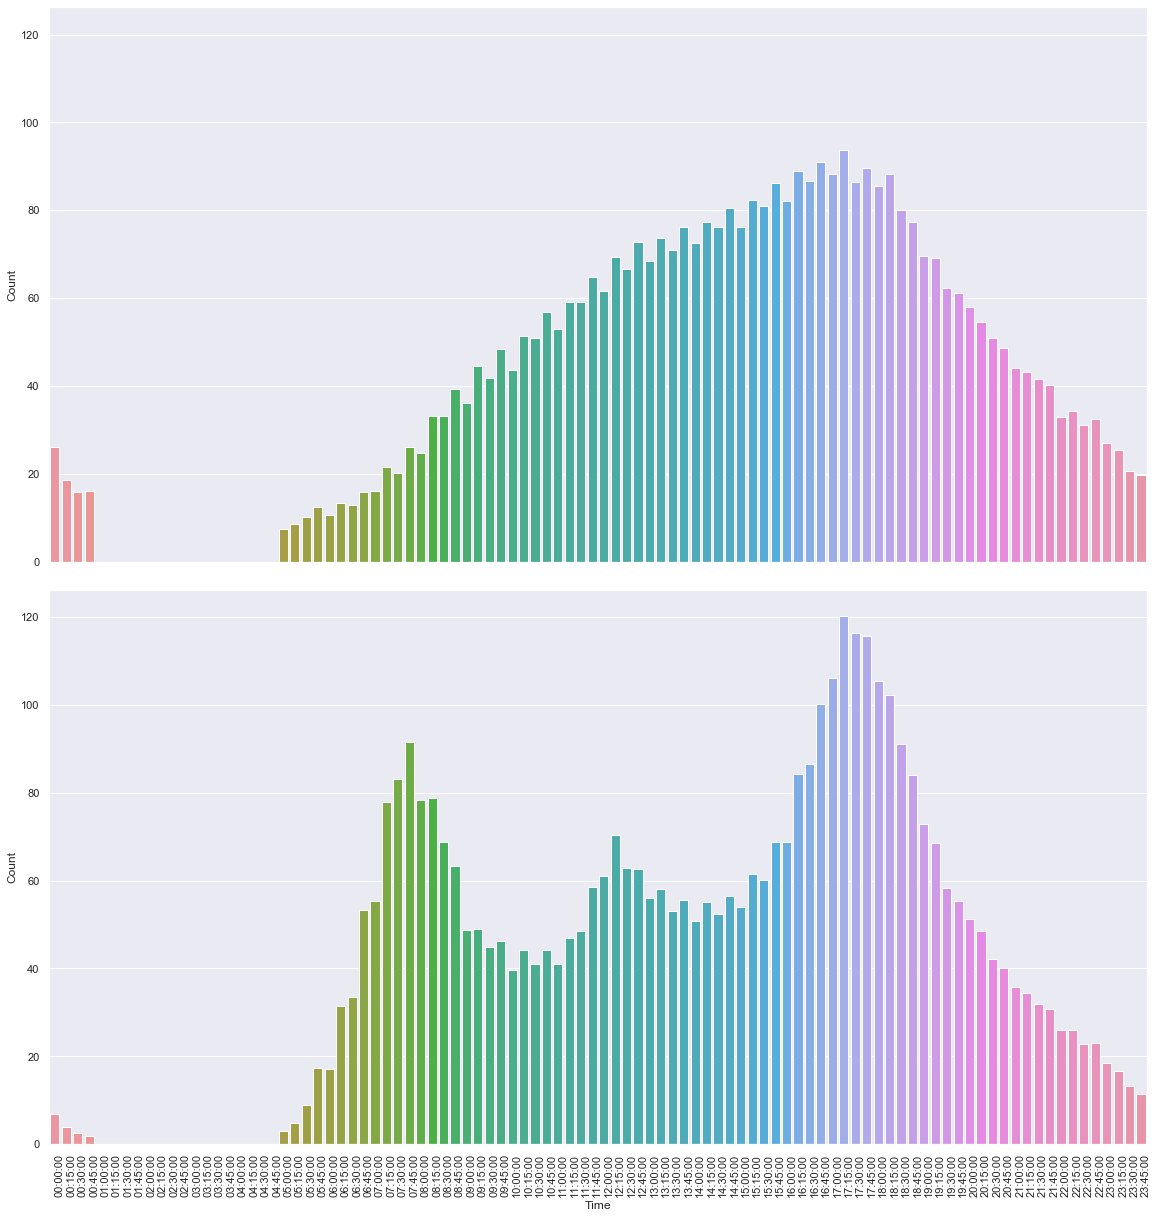

In [22]:
fig, (weekend, workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=spr_data.loc[(spr_data.WT.isin(spr_workdays)) & (spr_data.Station == "Bellinzona")],
    x="Time",
    y="Count",
    estimator=np.mean,
    ci=None,
    ax=workdays,
)
sns.barplot(
    data=spr_data.loc[(spr_data.WT.isin(spr_weekend)) & (spr_data.Station == "Bellinzona")],
    x="Time",
    y="Count",
    estimator=np.mean,
    ci=None,
    ax=weekend,
)
fig.autofmt_xdate(rotation=90, ha="left")

# Store finished data

In [23]:
with project_dir("axinova"):
    store_bin(spr_data, "spr_data_mapped.feather")

10:37:35 [INFO] Started storing feather file ...
10:37:35 [INFO] Writing to file C:\Users\kpf\data\axinova\spr_data_mapped.feather
10:37:35 [INFO] Written 11.2 MB
10:37:35 [INFO] ... finished storing feather file in 0.02s (0.02s CPU)
